In [1]:
# Jupyter Notebook: SQL Data Analysis

## Step 1: Setting up the Environment

# Import required libraries for the project
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a connection to a SQLite database (this will be an in-memory database)
conn = sqlite3.connect(':memory:')  # Use ':memory:' for in-memory database

# Load the dataset using Pandas from an open-source dataset
# Here we use the Titanic dataset as an example
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Preview the data
df.head()

# Store the dataset into SQL for analysis
df.to_sql('titanic', conn, if_exists='replace', index=False)

891

In [2]:
## Step 2: Data Extraction

# Use SQL to extract some basic information about the dataset

# 1. View first few rows of the dataset
query = '''
SELECT * FROM titanic
LIMIT 5
'''  
pd.read_sql(query, conn)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [3]:
# 2. Extract some statistics about passenger survival rate
query = '''
SELECT 
    Survived,
    COUNT(*) AS Count
FROM 
    titanic
GROUP BY 
    Survived
'''  
survival_stats = pd.read_sql(query, conn)
survival_stats

,Survived,Count
0,0,549
1,1,342


In [4]:
## Step 3: Data Transformation

# Here, we clean and transform the data using SQL queries to ensure it's ready for deeper analysis.

# 1. Handling missing values: Count the number of null values in each column
query = '''
SELECT 
    COUNT(*) - COUNT(Age) AS Missing_Age,
    COUNT(*) - COUNT(Embarked) AS Missing_Embarked
FROM 
    titanic
'''  
pd.read_sql(query, conn)

,Missing_Age,Missing_Embarked
0,177,2


In [14]:
# 2. Fill missing Age values with the median Age, and missing Embarked with the most common value
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Update the SQL table with the transformed data
df.to_sql('titanic', conn, if_exists='replace', index=False)

# 3. Create a new column for Age Group classification in SQL
# 1. Add the new column
query_add_column = '''
ALTER TABLE titanic
ADD COLUMN Age_Group TEXT;
'''  
conn.execute(query_add_column)

# 2. Update the new column with Age Group classification
query_update_column = '''
UPDATE titanic
SET Age_Group = CASE
    WHEN Age < 18 THEN 'Child'
    WHEN Age >= 18 AND Age < 60 THEN 'Adult'
    ELSE 'Senior'
END
'''  
conn.execute(query_update_column)

In [15]:
## Step 4: Data Analysis with SQL

# 1. Analyze the survival rate by gender
query = '''
SELECT 
    Sex,
    Survived,
    COUNT(*) AS Count
FROM 
    titanic
GROUP BY 
    Sex, Survived
'''  
gender_survival_stats = pd.read_sql(query, conn)
gender_survival_stats

,Sex,Survived,Count
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


In [12]:
# 2. Analyze the survival rate by passenger class
query = '''
SELECT 
    Pclass,
    Survived,
    COUNT(*) AS Count
FROM 
    titanic
GROUP BY 
    Pclass, Survived
'''  
class_survival_stats = pd.read_sql(query, conn)
class_survival_stats

,Pclass,Survived,Count
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


In [16]:
# 3. Analyze the survival rate by age group
query = '''
SELECT 
    Age_Group,
    Survived,
    COUNT(*) AS Count
FROM 
    titanic
GROUP BY 
    Age_Group, Survived
'''  
age_group_stats = pd.read_sql(query, conn)
age_group_stats

,Age_Group,Survived,Count
0,Adult,0,478
1,Adult,1,274
2,Child,0,52
3,Child,1,61
4,Senior,0,19
5,Senior,1,7


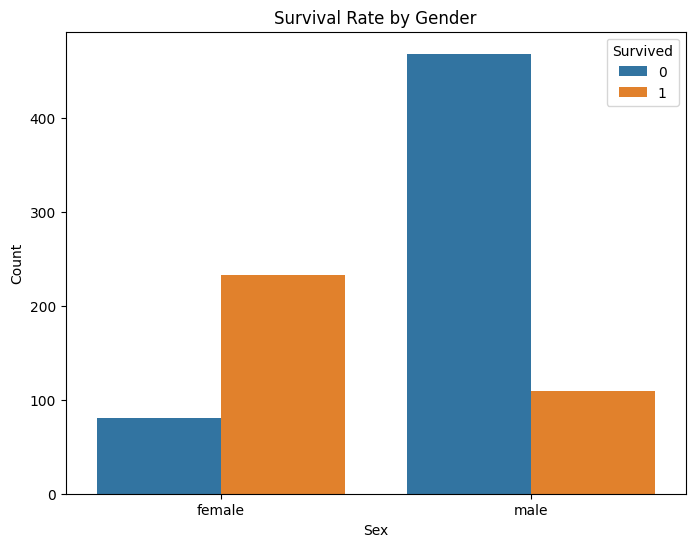

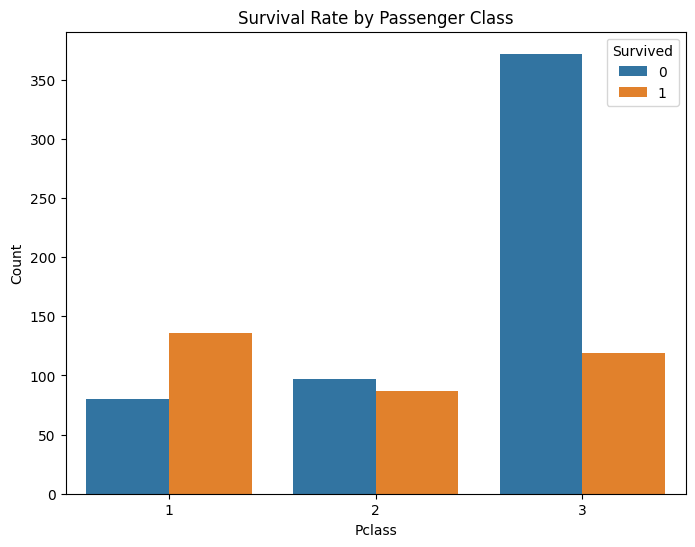

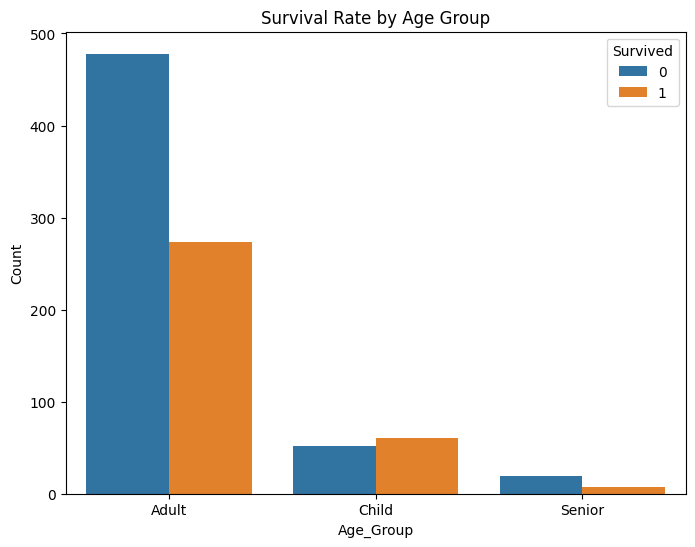

In [18]:
## Step 5: Data Visualization

# Visualize the survival rate by gender
plt.figure(figsize=(8,6))
sns.barplot(x='Sex', y='Count', hue='Survived', data=gender_survival_stats)
plt.title('Survival Rate by Gender')
plt.show()

# Visualize the survival rate by passenger class
plt.figure(figsize=(8,6))
sns.barplot(x='Pclass', y='Count', hue='Survived', data=class_survival_stats)
plt.title('Survival Rate by Passenger Class')
plt.show()

# Visualize the survival rate by age group
plt.figure(figsize=(8,6))
sns.barplot(x='Age_Group', y='Count', hue='Survived', data=age_group_stats)
plt.title('Survival Rate by Age Group')
plt.show()

In [19]:
## Step 6: Conclusion

# Summarize findings
'''
From the analysis, we found:
- Females had a significantly higher survival rate compared to males.
- Passengers in the first class had a higher survival rate compared to those in second and third class.
- Children also had a higher survival rate compared to adults and seniors.
'''

# Close the SQL connection
conn.close()